**Deep Learning Final Project Notebook**

### 1. Libraries

In [49]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D

### 2. Load Data & Preprocess

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Because the UTKFace dataset contains over 23.000 images and the available resource (RAM) is limited, I cant load all of them into the memory at once. For that, tensor slices are used. Tensor slices only stores the file paths and labels of each image, dividing them into 'slices' which allows the model to process the dataset in small batches, preventing memory overflow. 

The steps for data processing are:
1. Extract target variable (age) from the file name. The format of the image names are "[age]\_[gender]\_[race]_[date&time].jpg".
2. Store the file names and age into lists.
3. The lists are converted into a numpy array so that they can be passed into tensorflow’s dataset pipeline.
4. The images are resized into a fixed size.
5. Images are then normalized.
6. Split dataset into train, validation, and test set with a ratio of 70 : 15 : 15

** CNN and ResNet have some difference in step 4 & 5, as the ResNet one must follow the original ImageNet configuration.


In [4]:
DATASET_PATH = "/content/drive/MyDrive/College/final-project-deep-learning/dataset/UTKFace"

filepaths = []
ages = []

for file in os.listdir(DATASET_PATH):
    if file.endswith(".jpg"):
        age = int(file.split("_")[0])
        filepaths.append(os.path.join(DATASET_PATH, file))
        ages.append(age)

filepaths = tf.constant(filepaths)
ages = tf.constant(ages)

filepaths = filepaths.numpy()
ages = ages.numpy()

print("Total images:", len(filepaths))

Total images: 23708


In [21]:
def load_and_preprocess_cnn(path, age):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (200, 200))

    img = tf.cast(img, tf.float32)
    img = img / 255.0

    return img, age

def load_and_preprocess_resnet(path, age):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))

    img = preprocess_input(img)

    return img, age

In [23]:
X_train, X_temp, y_train, y_temp = train_test_split(filepaths, ages, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [24]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_ds   = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_ds  = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_ds_cnn = train_ds.map(load_and_preprocess_cnn).batch(32).prefetch(1)
val_ds_cnn   = val_ds.map(load_and_preprocess_cnn).batch(32).prefetch(1)
test_ds_cnn  = test_ds.map(load_and_preprocess_cnn).batch(32).prefetch(1)

train_ds_resnet = train_ds.map(load_and_preprocess_resnet).batch(32).prefetch(1)
val_ds_resnet   = val_ds.map(load_and_preprocess_resnet).batch(32).prefetch(1)
test_ds_resnet  = test_ds.map(load_and_preprocess_resnet).batch(32).prefetch(1)

### 3. CNN

#### Modelling

This model is a simple convolutional neural network designed to estimate age from images. The first part of the model uses four convolutional layers that apply filters to the image to detect features such as edges, shapes, and eventually facial details related to age. Batch normalization stabilizes the activations, and max-pooling reduces the spatial size, allowing the network to focus on the most important features while reducing computation.

After feature extraction, the data is flattened and passed into dense layers, which learn how the extracted features relate to the target value (age). Dropout is used to prevent overfitting by randomly disabling neurons during training. The final dense layer outputs a single number representing the predicted age. The model is trained using the Adam optimizer, and the loss function MAE measures how far predicted ages are from the true values.


In [9]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(1)
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mae',
    metrics=['mae', 'mse']
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 198, 198, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 198, 198, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 99, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 97, 97, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 97, 97, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 46, 46, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 46, 46, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 23, 23, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 21, 21, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 21, 21, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    13,107,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,629,633 (51.99 MB)

 Trainable params: 13,628,673 (51.99 MB)

 Non-trainable params: 960 (3.75 KB)

#### Training

Two extra mechanisms are used to help the model learn more efficiently and prevent overfitting. Early stopping monitors the validation loss and stops training automatically if the model stops improving for a number of epochs (10). It will then return the model with the lowest val_loss. Reduce learning rate on plateu is used for adjusting learning rate dynamically during training, which might help the model achieve better convergence. The model is then trained on 50 epochs (max).

In [10]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

history = model.fit(
    train_ds_cnn,
    validation_data=val_ds_cnn,
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/50
519/519 ━━━━━━━━━━━━━━━━━━━━ 274s 504ms/step - loss: 16.0453 - mae: 16.0453 - mse: 457.2822 - val_loss: 13.0472 - val_mae: 13.0472 - val_mse: 311.1464 - learning_rate: 0.0010
Epoch 2/50
519/519 ━━━━━━━━━━━━━━━━━━━━ 61s 117ms/step - loss: 10.8291 - mae: 10.8291 - mse: 217.2302 - val_loss: 12.7375 - val_mae: 12.7375 - val_mse: 278.7616 - learning_rate: 0.0010
Epoch 3/50
519/519 ━━━━━━━━━━━━━━━━━━━━ 68s 131ms/step - loss: 9.4678 - mae: 9.4678 - mse: 172.0089 - val_loss: 8.9359 - val_mae: 8.9359 - val_mse: 145.5691 - learning_rate: 0.0010
Epoch 4/50
519/519 ━━━━━━━━━━━━━━━━━━━━ 95s 156ms/step - loss: 8.8283 - mae: 8.8283 - mse: 150.6152 - val_loss: 10.0789 - val_mae: 10.0789 - val_mse: 184.9835 - learning_rate: 0.0010
Epoch 5/50
519/519 ━━━━━━━━━━━━━━━━━━━━ 68s 130ms/step - loss: 8.4587 - mae: 8.4587 - mse: 138.4968 - val_loss: 12.8246 - val_mae: 12.8246 - val_mse: 273.5164 - learning_rate: 0.0010
Epoch 6/50
519/519 ━━━━━━━━━━━━━━━━━━━━ 61s 117ms/step - loss: 8.1824 - mae: 8.182

#### Evaluation

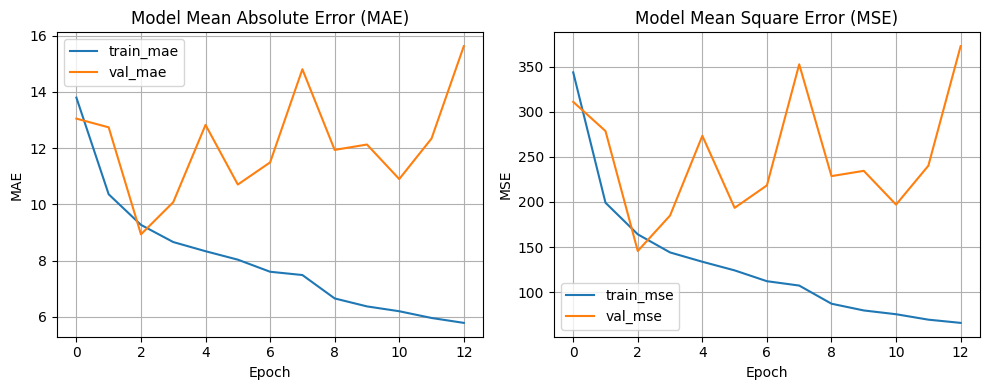

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].plot(history.history['mae'], label='train_mae')
axes[0].plot(history.history['val_mae'], label='val_mae')
axes[0].set_title('Model Mean Absolute Error (MAE)')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MAE')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(history.history['mse'], label='train_mse')
axes[1].plot(history.history['val_mse'], label='val_mse')
axes[1].set_title('Model Mean Square Error (MSE)')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MSE')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

The CNN model is able to learn quite effectively and efficiently, with its third epoch being the one taken (lowest val_loss). After the third epoch, the train and val losses diverged, which indicates that the model has stopped learning and is only memorizing the train data.

In [ ]:
test_loss, test_mae, test_mse = model.evaluate(test_ds_cnn)

y_pred = model.predict(test_ds_cnn).flatten()

y_true = []
for _, labels in test_ds_cnn.unbatch():
    y_true.append(labels.numpy())
y_true = np.array(y_true)

MAE: 8.58 years
MSE: 136.07
RMSE: 11.67 years


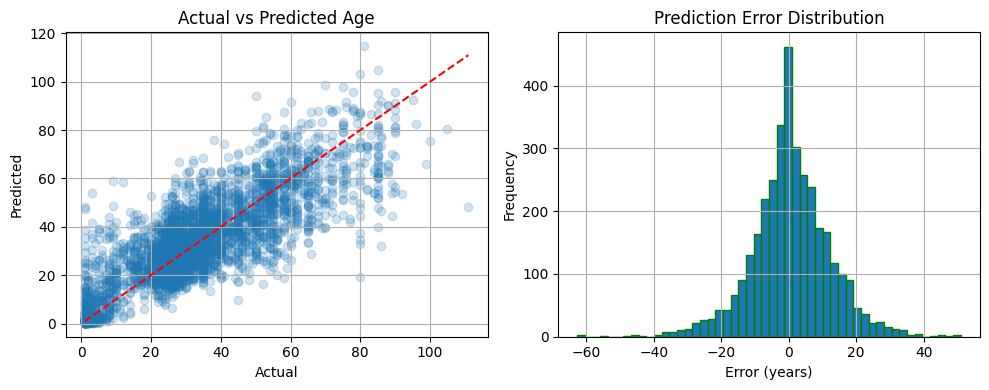

In [35]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.scatter(y_true, y_pred, alpha=0.2)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Age')
plt.grid(True)

plt.subplot(1, 2, 2)
errors = y_pred - y_true
plt.hist(errors, bins=50, edgecolor='green')
plt.xlabel('Error (years)')
plt.ylabel('Frequency')
plt.title('Prediction Error Distribution')
plt.grid(True)

plt.tight_layout()

print(f"MAE: {test_mae:.2f} years")
print(f"MSE: {test_mse:.2f}")
print(f"RMSE: {np.sqrt(test_mse):.2f} years")
plt.show()

The left plot shows a clear positive relationship, meaning the model generally learns how age increases. Most younger and middle-aged predictions fall close to the diagonal line, but the spread grows for older ages. This means that the model becomes less accurate as age increases, an issue that could be caused by fewer samples and higher variability in that age range. The error distribution plot confirms this behavior. Most of the errors cluster around zero, but the center is slightly negative, meaning the model predicts younger ages more often than older ones. The majority of predictions fall within a reasonable error range, while a small number of large negative errors represent significant underestimations. Overall, the model performs consistently but shows a bias toward predicting lower ages, especially for older faces.

### 4. ResNet

#### Modelling

This model uses transfer learning by starting with a pretrained ResNet50 network instead of training a CNN from scratch. The ResNet50 loaded here comes with weights learned from ImageNet, which means it already knows how to detect general visual features such as edges, textures, shapes, and object structures.

Since it is originally a classification model, the classification layers are removed (include_top=False), and a custom regression head is added for it to be able to estimate ages. The ResNet base model is also froze to prevent the pretrained layers weights getting updated.


GlobalAveragePooling2D compresses the spatial feature maps into a single vector, keeping the most important information while reducing the number of parameters. Two dense layers with ReLU activation learn patterns linking the extracted features to age, and dropout helps reduce overfitting by randomly deactivating neurons during training. The final dense layer outputs a single value representing the predicted age.

The custom head while keeping the powerful ResNet50 backbone fixed is expected to give much better performance and stability then the previous model (CNN).

In [38]:
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False

# regression head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1)(x)

resnet_model = Model(inputs=base_model.input, outputs=output)

resnet_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mae',
    metrics=['mae', 'mse']
)

resnet_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,768,385 (94.48 MB)

 Trainable params: 1,180,673 (4.50 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

#### Training

In [39]:
early_stopping_resnet = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_resnet = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

history_resnet = resnet_model.fit(
    train_ds_resnet,
    validation_data=val_ds_resnet,
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping_resnet, reduce_lr_resnet],
    verbose=1
)

Epoch 1/50
519/519 ━━━━━━━━━━━━━━━━━━━━ 149s 262ms/step - loss: 11.4315 - mae: 11.4315 - mse: 250.2347 - val_loss: 7.6455 - val_mae: 7.6455 - val_mse: 113.3257 - learning_rate: 0.0010
Epoch 2/50
519/519 ━━━━━━━━━━━━━━━━━━━━ 110s 212ms/step - loss: 8.6062 - mae: 8.6062 - mse: 139.5083 - val_loss: 7.3783 - val_mae: 7.3783 - val_mse: 106.0691 - learning_rate: 0.0010
Epoch 3/50
519/519 ━━━━━━━━━━━━━━━━━━━━ 105s 202ms/step - loss: 8.1952 - mae: 8.1952 - mse: 127.8631 - val_loss: 7.1534 - val_mae: 7.1534 - val_mse: 101.1415 - learning_rate: 0.0010
Epoch 4/50
519/519 ━━━━━━━━━━━━━━━━━━━━ 133s 185ms/step - loss: 7.9718 - mae: 7.9718 - mse: 122.1121 - val_loss: 7.1115 - val_mae: 7.1115 - val_mse: 98.8899 - learning_rate: 0.0010
Epoch 5/50
519/519 ━━━━━━━━━━━━━━━━━━━━ 96s 185ms/step - loss: 7.7699 - mae: 7.7699 - mse: 116.2157 - val_loss: 7.3170 - val_mae: 7.3170 - val_mse: 107.5206 - learning_rate: 0.0010
Epoch 6/50
519/519 ━━━━━━━━━━━━━━━━━━━━ 96s 185ms/step - loss: 7.6983 - mae: 7.6983 - mse:

#### Evaluation

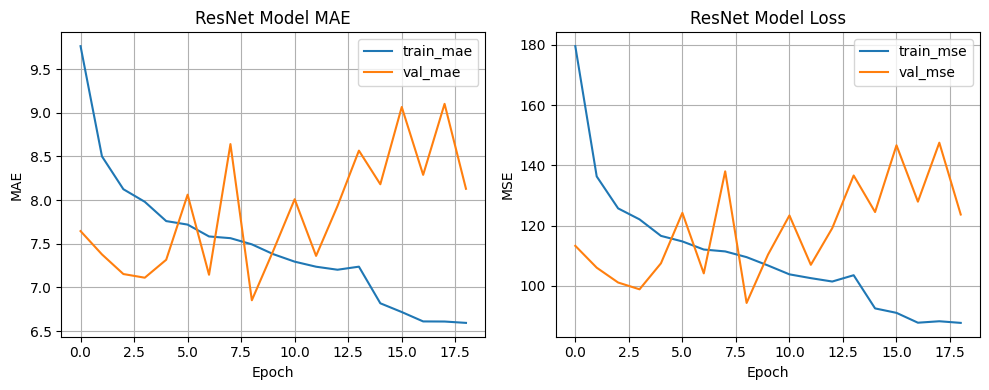

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].plot(history_resnet.history['mae'], label='train_mae')
axes[0].plot(history_resnet.history['val_mae'], label='val_mae')
axes[0].set_title('ResNet Model MAE')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MAE')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(history_resnet.history['mse'], label='train_mse')
axes[1].plot(history_resnet.history['val_mse'], label='val_mse')
axes[1].set_title('ResNet Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MSE')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

Compared to the CNN model, this looks more stable, achieving lower MAE and MSE. The train and val losses diverges early as well, at the ninth epoch.

In [51]:
test_loss_resnet, test_mae_resnet, test_mse_resnet = resnet_model.evaluate(test_ds_resnet)

y_pred_resnet = resnet_model.predict(test_ds_resnet).flatten()

y_true = []
for _, labels in test_ds_resnet.unbatch():
    y_true.append(labels.numpy())

y_true = np.array(y_true)


112/112 ━━━━━━━━━━━━━━━━━━━━ 21s 181ms/step - loss: 6.8224 - mae: 6.8224 - mse: 97.1060
112/112 ━━━━━━━━━━━━━━━━━━━━ 17s 155ms/step


MAE: 6.72 years
MSE: 93.78
RMSE: 9.68 years


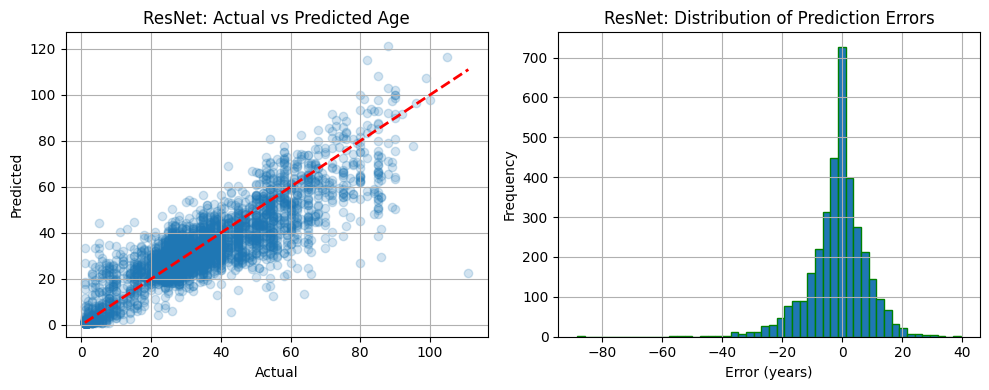

In [52]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.scatter(y_true, y_pred_resnet, alpha=0.2)
plt.plot([y_true.min(), y_true.max()],
         [y_true.min(), y_true.max()],
         'r--', lw=2)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("ResNet: Actual vs Predicted Age")
plt.grid(True)

plt.subplot(1, 2, 2)
errors_resnet = y_pred_resnet - y_true
plt.hist(errors_resnet, bins=50, edgecolor='green')
plt.xlabel("Error (years)")
plt.ylabel("Frequency")
plt.title("ResNet: Distribution of Prediction Errors")
plt.grid(True)

plt.tight_layout()

print(f"MAE: {test_mae_resnet:.2f} years")
print(f"MSE: {test_mse_resnet:.2f}")
print(f"RMSE: {np.sqrt(test_mse_resnet):.2f} years")
plt.show()

Similarly, this model also have the same issue as the CNN model, often underestimating people's age. However, the errors appear more tightly concentrated around zero, suggesting that ResNet produces more consistent and accurate predictions overall, even though a few large errors still occur.

#### Save Model

In [44]:
resnet_model.save('resnet_age_prediction_model.h5')

### 5. Comparison

In [45]:
comparison = pd.DataFrame({
    'Model': ['CNN', 'ResNet50'],
    'MAE': [test_mae, test_mae_resnet],
    'MSE': [test_mse, test_mse_resnet],
    'RMSE': [np.sqrt(test_mse), np.sqrt(test_mse_resnet)]
})

print(comparison)

      Model       MAE         MSE       RMSE
0       CNN  8.582092  136.074341  11.665091
1  ResNet50  6.723834   93.779495   9.683981


Overall both models performed fairly well. The ResNet with regression head model performed better as expected, although the CNN architecture and the hyperparameters used are open for changes and the results could've been different. The model’s performance could be improved by tuning hyperparameters, adding regularization, or using techniques such as data augmentation to reduce overfitting. Additionally, experimenting with more advanced architectures or fine-tuning deeper layers of ResNet may further enhance prediction accuracy.
